In [1]:
# import os
# # os.chdir('..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pprint import pprint
import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'config.py',
 'coverage.py',
 'coverage_demo.ipynb',
 'coverage_notebook.ipynb',
 'duplicate_score.py',
 'generating_mab2rec_data.ipynb',
 'mab2rec.ipynb',
 'meal_config.py',
 'meal_info.py',
 'meal_recommender.py',
 'meal_recommender_demo.ipynb',
 'metrics.py',
 'metrics_demo.ipynb',
 'user_constraints.py',
 'user_constraints_demo.ipynb',
 '__pycache__']

# Model Selection

* The goal of this notebook is to perform model selection by benchmarking several recommender algorithms using cross-validation.
* The strategy to build recommenders consist of **two steps**: 
    * First, we perform model selection (this notebook) to identify a small set of candidate recommenders that perform well with respect to evaluation metrics. 
    * Second, we conduct further benchmarks, ([evaluation notebook](https://github.com/fidelity/mab2rec/blob/main/notebooks/4_evaluation.ipynb)) to stress test the top performing algorithms further. 
* For input data, we use the famous [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/).
* For recommendation algorithms, we take advantage of [MABWiser](https://github.com/fidelity/mabwiser) ([IJAIT'21](https://www.worldscientific.com/doi/abs/10.1142/S0218213021500214), [ICTAI'19](https://ieeexplore.ieee.org/document/8995418)) for bandit policies. 
* For performance evaluation, we employ [Jurity](https://github.com/fidelity/jurity) for various metrics.


# Table of Contents
1. [Input Data](#Input-Data)
2. [Recommenders](#Recommenders)
3. [Metrics](#Metrics)
4. [Benchmark](#Benchmark)
5. [Results](#Results)
6. [Analysis](#Analysis)


# Input Data

* Input data is as described in [Data Overview](https://github.com/fidelity/mab2rec/blob/main/notebooks/1_data_overview.ipynb).

In [4]:
# Input data
train_data = "../mab2rec_data/binary_data_train.csv"
user_features = "../mab2rec_data/features_user.csv"
item_features = "../mab2rec_data/features_meals.csv"

# Read data
train_df = pd.read_csv(train_data)
user_features_df = pd.read_csv(user_features)
item_features_df = pd.read_csv(item_features)

# Recommenders

* Let's start with **a set of recommenders** that we want to train and evaluate using cross-validation.
* For baselines, we use `Random` and `Popularity`.
* For parametric bandits, we use `LinGreedy` and `LinUCB` that are highly-performing algorithms. 
* For non-parametric bandits, we use `ClustersTS` as a non-parametric policy that combines KMeans clustering neighborhood policy with Thompson Sampling learning policy. 

In [5]:
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

# Set of recommenders to benchmark
recommenders = {
      "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
      "Popularity": BanditRecommender(learning_policy=LearningPolicy.Popularity()),
      "LinGreedy": BanditRecommender(learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)),
      "LinUCB": BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=10)),
      "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
      "ClustersTS": BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(), 
                                      neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10))
}

recommenders

{'Random': <mab2rec.rec.BanditRecommender at 0x206baa69c50>,
 'Popularity': <mab2rec.rec.BanditRecommender at 0x20698cd9250>,
 'LinGreedy': <mab2rec.rec.BanditRecommender at 0x206baa10f10>,
 'LinUCB': <mab2rec.rec.BanditRecommender at 0x206b9959b50>,
 'LinTS': <mab2rec.rec.BanditRecommender at 0x206ba6953d0>,
 'ClustersTS': <mab2rec.rec.BanditRecommender at 0x206a9ecb3d0>}

# Metrics

* Let's define the **list of *evaluation metrics** from [Jurity](https://github.com/fidelity/jurity) to compare the different algorithms. 
* Recommendation metrics include `AUC`, `CTR`, `Precision`, `Recall`, `NDCG`, and `MAP`.
* See [Jurity documentation](https://fidelity.github.io/jurity/about_reco.html#) for the defintions of these metrics.

In [6]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {'click_column': 'score', 'user_id_column': 'user_id', 'item_id_column':'item_id'}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params,  k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))
    
metrics

# Benchmark 
* **Benchmark** utility to **train** each of the recommender algorithms on the train data. 
* **Generates up to top-k recommendations** using cv-fold cross-validation.
* **Evaluates** the results using the list of evaluation metrics.

In [7]:
from mab2rec.pipeline import benchmark

# Benchmark the set of recommenders for the list of metrics 
# using training data and user features with cross-validation
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=train_data, 
                                             cv=5,
                                             user_features=user_features)

# Results
* The **benchmark** function returns two dictionaries:
  * `reco_to_results`: the recommendations made by each algorithm on the (cross) validation data
  * `reco_to_metrics`: the specified evaluation metrics for each algorithm
* We use these result dictionaries to compare the performance of the different algorithms.

In [8]:
cv_fold = 0
pprint(reco_to_results[cv_fold].keys())
pprint(reco_to_results[cv_fold])

pprint(reco_to_metrics[cv_fold].keys())
pprint(reco_to_metrics[cv_fold])

dict_keys(['Random', 'Popularity', 'LinGreedy', 'LinUCB', 'LinTS', 'ClustersTS'])
{'ClustersTS':      user_id  item_id     score
0          2       25  0.730154
1          2       30  0.714286
2          2       20  0.713311
3          2       26  0.711741
4          2       14  0.703775
..       ...      ...       ...
135       70       69  0.707098
136       70       44  0.701392
137       70       17  0.701068
138       70       55  0.699207
139       70        1  0.698394

[140 rows x 3 columns],
 'LinGreedy':      user_id  item_id     score
0          2       68  0.679179
1          2       24  0.679179
2          2       11  0.679179
3          2       44  0.679179
4          2       52  0.679179
..       ...      ...       ...
135       70       25  0.702776
136       70       20  0.701561
137       70       68  0.698146
138       70       15  0.693339
139       70        6  0.675667

[140 rows x 3 columns],
 'LinTS':      user_id  item_id     score
0          2       62  0.6755

# Analysis

* Let's analyze each metric at different top-k recommendations. 
* Each plot displays the value of a given metric (y-axis), at a different _top-k_ (x-axis) for each of the algorithms (different lines).
* We observe that `LinGreedy` performs best on almost all metrics except for `AUC` where `LinUCB` performs better.

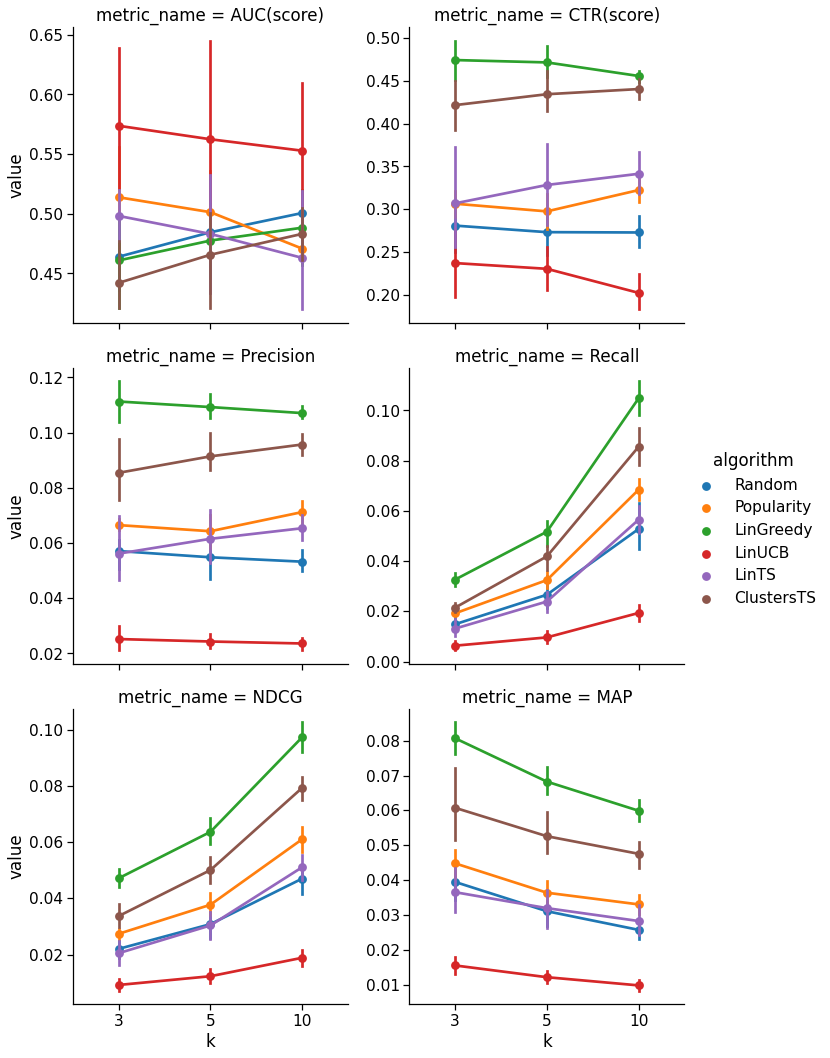

In [7]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2);

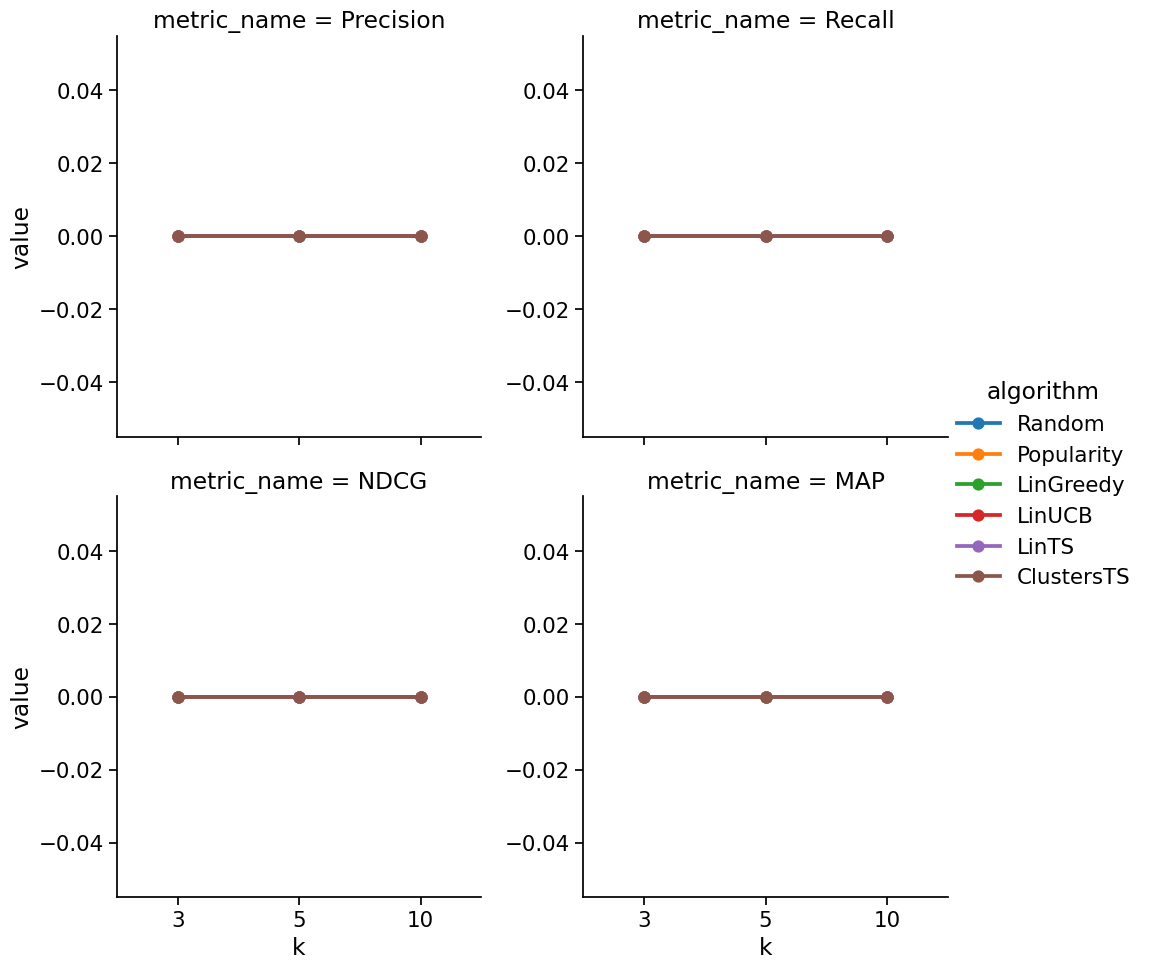

In [9]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2);